<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/Category_and_position_vlPFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Compare category and object position information in the early and late vlPFC responses

---
###Please ensure you have downloaded the required data from Figshare before proceeding.

**Google Colab:**



*   Upload the data to your Google Drive.
*   Select Google Drive in the widget below and mount your drive for the fastest access.




**Kaggle:**

*   Add the dataset to your notebook's Input directory (e.g., ../input/dataset-name).

*   Select Kaggle Input in the widget below.

**Local Computer:**

*   Store the downloaded files in a folder on your machine.

*   Select Local Storage in the widget below and paste the absolute path to that folder (e.g., /Users/name/data/).

In [ ]:
# ──────────────────────────────────────────────────────────────────────
# DATA SETUP WIDGET (Universal: Colab, Kaggle & Local)
# ──────────────────────────────────────────────────────────────────────
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import shutil
from pathlib import Path

# --- 1. CONFIGURATION
REQUIRED_FILES = [
    'Spike_count_even_sessions.npy',
    'Spike_count_odd_sessions.npy',
    'hvm_public_extended_meta.csv'
]
DEST_DIR = Path("downloads")
DEST_DIR.mkdir(exist_ok=True)

# Detect Environment
IN_COLAB = 'google.colab' in str(get_ipython())
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# --- UI Elements ---
style = {'description_width': '120px'}
layout_full = widgets.Layout(width='98%')

header = widgets.HTML("<h2>📂 Data Import Manager</h2>")

# Determine options based on environment
options = ['Local Upload']
if IN_COLAB:
    options = ['Google Drive', 'Local Upload']
elif IN_KAGGLE:
    options = ['Kaggle Input', 'Local Upload']
else:
    options = ['Local Storage', 'Local Upload']

source_toggle = widgets.ToggleButtons(
    options=options,
    description='Select Source:',
    button_style='info',
    style=style
)

# Input for Paths
path_input = widgets.Text(
    value='/content/drive/MyDrive/vlPFC_Geometry' if IN_COLAB else '.',
    placeholder='Enter absolute path to data folder...',
    description='Data Path:',
    disabled=False,
    layout=layout_full,
    style=style
)

btn_action = widgets.Button(
    description='Start Import',
    button_style='primary',
    icon='download',
    layout=widgets.Layout(width='200px')
)

out_log = widgets.Output(layout={'border': '1px solid #ddd', 'padding': '10px'})

# --- Logic ---
def update_ui(change):
    if source_toggle.value == 'Local Upload':
        path_input.layout.display = 'none'
    else:
        path_input.layout.display = 'flex'
        if source_toggle.value == 'Google Drive':
            path_input.description = 'Drive Path:'
        elif source_toggle.value == 'Local Storage':
            path_input.description = 'Local Path:'
        elif source_toggle.value == 'Kaggle Input':
            path_input.description = 'Input Path:'
            path_input.value = '/kaggle/input'

source_toggle.observe(update_ui, 'value')

def on_click_action(b):
    with out_log:
        clear_output()
        mode = source_toggle.value

        if mode == 'Local Upload':
            if IN_COLAB:
                from google.colab import files
                print("🚀 Upload files now (select all required files):")
                uploaded = files.upload()
                for name in uploaded:
                    shutil.move(name, DEST_DIR / name)
                print("\n✅ Upload complete.")
            else:
                print("⚠️ Manual upload widget is Colab-only.")
                print(f"👉 Please manually copy files to: {DEST_DIR.absolute()}")
            return

        src_path = Path(path_input.value)
        if mode == 'Google Drive' and not src_path.exists():
            from google.colab import drive
            print("🔄 Mounting Google Drive...")
            drive.mount('/content/drive')

        if not src_path.exists():
            print(f"❌ Error: Path not found: {src_path}")
            return

        print(f"🔎 Scanning {src_path} for files...")
        for fname in REQUIRED_FILES:
            dest = DEST_DIR / fname
            if dest.exists():
                print(f"   • {fname}: Already exists (Skipping)")
                continue

            found = list(src_path.rglob(fname))
            if found:
                print(f"   • Copying {fname}...", end=" ")
                shutil.copy(found[0], dest)
                print("Done.")
            else:
                print(f"   ❌ {fname}: Not found in source path.")

        missing = [f for f in REQUIRED_FILES if not (DEST_DIR / f).exists()]
        if not missing:
            print("\n🎉 Success! All files are in 'downloads/'. Run the next cell.")
        else:
            print(f"\n⚠️ Missing files: {missing}")

update_ui(None)
btn_action.on_click(on_click_action)
display(header, source_toggle, path_input, btn_action, out_log)

# First, download data and import toolboxes

In [ ]:
import os, re, pickle, warnings, time
from pathlib import Path
from itertools import combinations
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import jit
# Determine the path to the repository based on the environment
IN_COLAB = False
IN_KAGGLE = False # Assuming not in Kaggle for now
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass

if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils'))

from extract_and_download_data import unzip
from image_processing import m_pathway_filter_gaussian

FIG_DIR = Path("Figures") # Convert to Path object
os.makedirs(FIG_DIR, exist_ok=True)
CACHE_DIR = Path(".cache");   CACHE_DIR.mkdir(exist_ok=True) # From Category decoding

# ──────────────────────────────────────────────────────────────────────
# Path Definitions (Data assumed to be in 'downloads/')
# ──────────────────────────────────────────────────────────────────────
DOWNLOAD_DIR = Path("downloads")
meta_downloaded_path = DOWNLOAD_DIR / "hvm_public_extended_meta.csv"
even_downloaded_path = DOWNLOAD_DIR / "Spike_count_even_sessions.npy"
odd_downloaded_path  = DOWNLOAD_DIR / "Spike_count_odd_sessions.npy"

# Verify files are present
if not (meta_downloaded_path.exists() and even_downloaded_path.exists() and odd_downloaded_path.exists()):
    raise FileNotFoundError("Missing files in 'downloads/'. Please run the Data Import Widget above.")

meta_downloaded = meta_downloaded_path.exists()
even_downloaded_check = even_downloaded_path.exists()
odd_downloaded_check = odd_downloaded_path.exists()


if not (meta_downloaded ):
    print("Failed to download necessary files. Exiting.")
    # exit() # Do not exit, just skip the parts that require these files


# Decode category

Pairwise category decoding — Neural (50–90 ms)…
Pairwise category decoding — Neural (100–200 ms)…
Saved:
  Figures/pairwise_combined_upper_early_lower_late_neural.png
  Figures/pairwise_combined_upper_early_lower_late_neural.svg
  Figures/pairwise_combined_upper_early_lower_late_neural.pdf


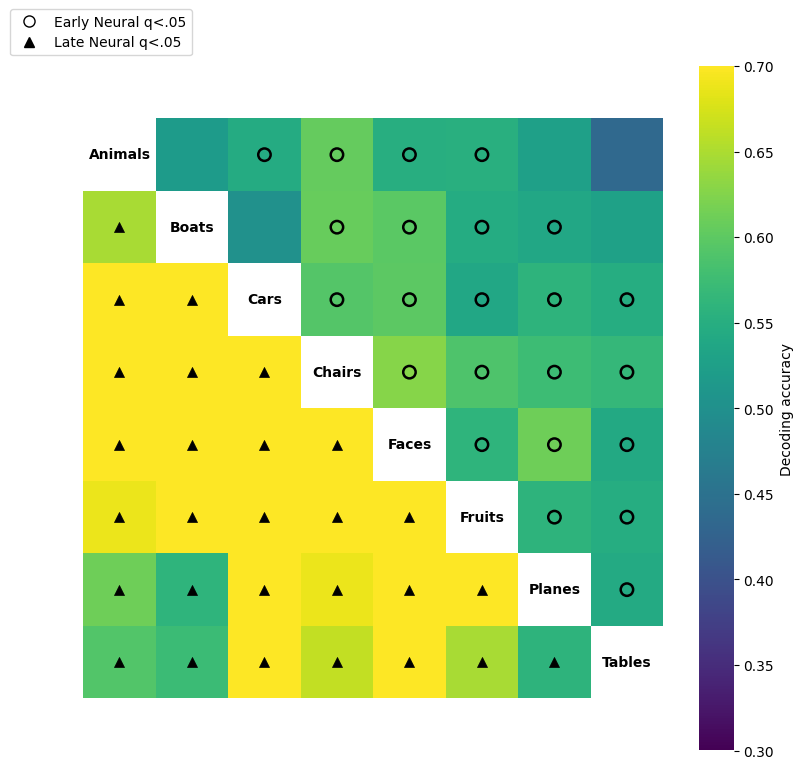

In [ ]:
# ========================== Pairwise Category Decoding ========================
import re, os
from pathlib import Path, PurePath
from itertools import combinations
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# --- IO / Paths you already had somewhere above ---
# Expect these to be defined: meta_downloaded_path, even_downloaded_path, odd_downloaded_path
FIG_DIR = Path("Figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Load & filter metadata ----------
meta = pd.read_csv(meta_downloaded_path)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# ---------- Helpers ----------
def flatten(data, t_idx):
    data = data[:, :, t_idx]
    return data.reshape(data.shape[0], -1)

def decode_pair(cat1, cat2, X_flat, labels, obj_names):
    """
    Pairwise decoding with leave‑one‑object‑per‑category out.
    Aggregates per‑trial probabilities across all (o1,o0) test folds.
    """
    mask_pair  = (labels == cat1) | (labels == cat2)
    X_pair_all = X_flat[mask_pair]
    y_pair_all = (labels[mask_pair] == cat1).astype(int)
    obj_pair   = obj_names[mask_pair]

    # PCA fitted outside pair images to avoid leakage
    train_mask_for_pca = (labels != cat1) & (labels != cat2)
    pca_global = PCA(n_components=50, random_state=42).fit(X_flat[train_mask_for_pca])

    n_pair = len(X_pair_all)
    sum_pos  = np.zeros(n_pair, dtype=float)
    sum_corr = np.zeros(n_pair, dtype=float)
    counts   = np.zeros(n_pair, dtype=int)

    objs1 = np.unique(obj_pair[y_pair_all == 1])
    objs0 = np.unique(obj_pair[y_pair_all == 0])

    clf = LogisticRegression(max_iter=500, solver="lbfgs", random_state=42)

    for o1 in objs1:
        for o0 in objs0:
            te_mask = (obj_pair == o1) | (obj_pair == o0)
            tr_mask = ~te_mask
            if tr_mask.sum() == 0 or te_mask.sum() == 0:
                continue

            X_tr = pca_global.transform(X_pair_all[tr_mask])
            X_te = pca_global.transform(X_pair_all[te_mask])
            y_tr = y_pair_all[tr_mask]
            y_te = y_pair_all[te_mask]

            clf.fit(X_tr, y_tr)
            proba_pos = clf.predict_proba(X_te)[:, 1]  # P(class==cat1)
            proba_corr = np.where(y_te == 1, proba_pos, 1 - proba_pos)

            idx_te_within_pair = np.flatnonzero(te_mask)
            sum_pos[idx_te_within_pair]  += proba_pos
            sum_corr[idx_te_within_pair] += proba_corr
            counts[idx_te_within_pair]   += 1

    valid = counts > 0
    if valid.sum() == 0:
        global_probs = np.full(len(labels), np.nan)
        global_probs[mask_pair] = np.nan
        return (cat1, cat2, np.nan, np.nan, global_probs)

    mean_pos  = np.full(n_pair, np.nan);  mean_pos[valid]  = sum_pos[valid] / counts[valid]
    mean_corr = np.full(n_pair, np.nan);  mean_corr[valid] = sum_corr[valid] / counts[valid]

    preds = (mean_pos[valid] >= 0.5).astype(int)
    acc   = (preds == y_pair_all[valid]).mean()
    k     = int(acc * valid.sum())
    pval  = binomtest(k, n=valid.sum(), p=0.5, alternative="greater").pvalue

    global_probs = np.full(len(labels), np.nan)
    global_probs[mask_pair] = mean_corr
    return (cat1, cat2, acc, pval, global_probs)

def parallel_decoding(X_flat, labels_cat, objects, cat_pairs):
    """Decode every category pair in parallel; return matrices and per-trial means."""
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(decode_pair)(c1, c2, X_flat, labels_cat, objects)
        for c1, c2 in cat_pairs
    )

    acc  = {(c1, c2): a for c1, c2, a, _, _ in results}
    pval = {(c1, c2): p for c1, c2, _, p, _ in results}
    probs= {(c1, c2): pr for c1, c2, _, _, pr in results}

    prob_matrix = np.stack([probs[pair] for pair in cat_pairs], axis=1)
    mean_trial  = np.nanmean(prob_matrix, axis=1)

    # FDR over all pairs
    p_vals = np.array([pval[pair] for pair in cat_pairs])
    _, q, _, _ = multipletests(p_vals, method="fdr_bh")
    qdict = {pair: qv for pair, qv in zip(cat_pairs, q)}

    categories = np.unique(labels_cat)
    nC = len(categories)
    A  = np.full((nC, nC), np.nan)
    S  = np.zeros((nC, nC), bool)
    for (c1, c2) in cat_pairs:
        i = np.where(categories == c1)[0][0]
        j = np.where(categories == c2)[0][0]
        if i < j:
            A[i, j] = acc[(c1, c2)]
            S[i, j] = qdict[(c1, c2)] < 0.05
    return A, S, probs, mean_trial

def plot_combined_upper_early_lower_late(A_neu_early, S_neu_early, A_neu_late, S_neu_late, categories,
                                         vmin=.3, vmax=.7, cmap="viridis"):
    """
    Build one matrix where:
      - Upper triangle (i<j): Early Neural accuracies
      - Lower triangle (i>j): Late Neural accuracies
      - Diagonal: blank (with category names written inside)
    Significance:
      - Early Neural: open white circle '◦' on upper cells with q<.05
      - Late Neural   : filled triangle '▲' on lower cells with q<.05
    """
    nC = len(categories)
    C   = np.full((nC, nC), np.nan)
    SigEarly= np.zeros((nC, nC), bool)
    SigLate= np.zeros((nC, nC), bool)

    # Upper: Early Neural (already stored on upper in A_neu_early)
    if A_neu_early is not None:
        upper = ~np.isnan(A_neu_early)
        C[upper] = A_neu_early[upper]
        SigEarly[upper] = S_neu_early[upper]

    # Lower: Late Neural — our A_neu_late is also upper-only, so mirror into lower
    if A_neu_late is not None:
        upper = ~np.isnan(A_neu_late)
        # write to the symmetric lower cells
        C.T[upper] = A_neu_late[upper]
        SigLate.T[upper] = S_neu_late[upper]


    # Heatmap without ticks; diagonal left NaN for text overlay
    fig, ax = plt.subplots(figsize=(8.4, 7.8))
    mask = np.isnan(C)
    hm = sns.heatmap(C, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask,
                     cbar=True, square=True, ax=ax,
                     xticklabels=False, yticklabels=False,
                     cbar_kws={"label": "Decoding accuracy"})

    # Diagonal category names
    for i, cat in enumerate(categories):
        ax.text(i + 0.5, i + 0.5, str(cat),
                ha="center", va="center", fontsize=10, fontweight="bold",
                color="black", rotation=0)

    # Significance overlays
    # Early Neural (upper): open white circles
    for i in range(nC):
        for j in range(i+1, nC):
            if SigEarly[i, j]:
                ax.scatter(j + 0.5, i + 0.5, s=80,
                           facecolors="none", edgecolors="black", linewidths=1.8)

    # Late Neural (lower): filled triangles
    for i in range(1, nC):
        for j in range(0, i):
            if SigLate[i, j]:
                ax.scatter(j + 0.5, i + 0.5, s=52, marker="^",
                           facecolors="black", edgecolors="black", linewidths=0.5)


    # Custom legend
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0], [0], marker='o', linestyle='None', markersize=8,
               markerfacecolor='none', markeredgecolor='black', label='Early Neural q<.05'),
        Line2D([0], [0], marker='^', linestyle='None', markersize=7,
               markerfacecolor='black', markeredgecolor='black', label='Late Neural q<.05'),
    ]
    ax.legend(handles=legend_elems, loc='upper right', bbox_to_anchor=(.2, 1.2))
    plt.tight_layout()
    out_svg = FIG_DIR / "pairwise_combined_upper_early_lower_late_neural.svg"
    out_png = FIG_DIR / "pairwise_combined_upper_early_lower_late_neural.png"
    out_pdf = FIG_DIR / "pairwise_combined_upper_early_lower_late_neural.pdf"
    fig.savefig(out_svg); fig.savefig(out_png, dpi=300); fig.savefig(out_pdf)
    print(f"Saved:\n  {out_png}\n  {out_svg}\n  {out_pdf}")
    plt.show()


# ------------------------------ Run pairwise decoding -------------------------
meta_df = meta.copy()
labels_cat = meta_df["category_name"].values
objects    = meta_df["object_name"].values
categories_unique = np.unique(labels_cat)
cat_pairs  = list(combinations(categories_unique, 2))

A_neu_early = S_neu_early = A_neu_late = S_neu_late = None

# Neural early features
if Path(even_downloaded_path).exists() and Path(odd_downloaded_path).exists():
    print("Pairwise category decoding — Neural (50–90 ms)…")
    rate_even = np.load(even_downloaded_path, allow_pickle=True)
    rate_odd  = np.load(odd_downloaded_path,  allow_pickle=True)
    even_raw, odd_raw = rate_even, rate_odd
    early_idx = slice(5, 9)  # 50–90 ms
    X_early = flatten((even_raw[valid_idx] + odd_raw[valid_idx]) / 2, early_idx)
    A_neu_early, S_neu_early, _, _ = parallel_decoding(X_early, labels_cat, objects, cat_pairs)

    # Neural late features
    print("Pairwise category decoding — Neural (100–200 ms)…")
    late_idx = slice(10, 20) # 100-200 ms
    X_late = flatten((even_raw[valid_idx] + odd_raw[valid_idx]) / 2, late_idx)
    A_neu_late, S_neu_late, _, _ = parallel_decoding(X_late, labels_cat, objects, cat_pairs)

else:
    print("Skipping Neural pairwise decoding (missing spike files).")


# Plot the combined heatmap
plot_combined_upper_early_lower_late(A_neu_early, S_neu_early, A_neu_late, S_neu_late, categories_unique)

# Decode position

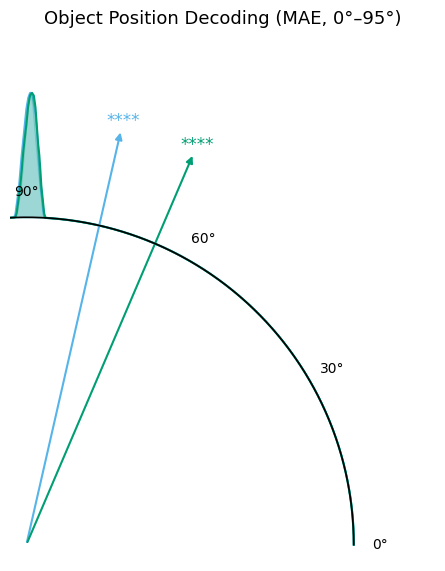

Figure saved → Figures/objpos_decoding_quartercircle_deg.png
                 Figures/objpos_decoding_quartercircle_deg.svg
                 Figures/objpos_decoding_quartercircle_deg.pdf


In [ ]:
def load_and_align(pkl_path, meta_df):
    with open(pkl_path, "rb") as fh:
        d = pickle.load(fh)
    X = d["penultimate"]
    if X.ndim > 2:
        X = X.reshape(X.shape[0], -1)
    names = [Path(n).stem for n in d["image_names"]]
    idx = [names.index(b) for b in meta_df["base"]]
    return X[idx].astype(np.float64)

def predict_angles(net, pkl_path, meta_df, y_target, categories):
    X = load_and_align(pkl_path, meta_df)
    pred_t = np.zeros_like(y_target, dtype=np.float64)
    for cat in categories:
        tr = meta_df["category_name"] != cat
        te = ~tr
        pca = PCA(n_components=50, random_state=42)
        Xtr = pca.fit_transform(X[tr])
        Xte = pca.transform(X[te])
        reg = LinearRegression().fit(Xtr, y_target[tr])
        pred_t[te] = reg.predict(Xte)
    return np.arctan2(pred_t[:, 1], pred_t[:, 0])

def circ_diff(a, b):
    return np.arctan2(np.sin(a - b), np.cos(a - b))

def perm_pvalue(empirical, null_samples):
    if null_samples is None or len(null_samples) == 0 or np.isnan(empirical):
        return np.nan
    return (np.sum(null_samples <= empirical) + 1) / (len(null_samples) + 1)

def p_to_stars(p):
    if np.isnan(p):  return ''
    if p < 1e-4:     return '****'
    if p < 1e-3:     return '***'
    if p < 1e-2:     return '**'
    if p < 5e-2:     return '*'
    return ''

# ───────────────────────── Quarter‑circle drawing ─────────────────────────
THETA_MAX_DEG = 95   # extend slightly beyond 90° to include left KDE tail
THETA_MAX     = np.deg2rad(THETA_MAX_DEG)

def _deg_label(ax, R, deg,zorder = 1):
    th = np.deg2rad(deg)
    ax.text(R*1.08*np.cos(th), R*1.08*np.sin(th), f'{deg}°',
            ha='center', va='center', fontsize=10, zorder=zorder)

def quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX, zorder=1):
    """Draw only a quarter of a circle (0° → ~95°) with degree labels."""
    t = np.linspace(0, theta_max, 300)
    ax.plot(R*np.cos(t), R*np.sin(t), lw=1.2, color='black', zorder=zorder)

    # Degree labels around the arc
    for deg in (0, 30, 60, 90):
        _deg_label(ax, R, deg,zorder= zorder)
    # Add black quarter circle

    # Neat framing for the first quadrant
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-R*0.05, R*1.25)
    ax.set_ylim(-R*0.05, R*1.55)
    ax.axis('off')

def draw_kde_bump(ax, samples, *,
                  R=1.0, height=0.35, n=400, color="black",
                  alpha_fill=0.22, lw=2.0, z=3, theta_max=THETA_MAX):
    """
    Draw a KDE "bump" outside the quarter arc.
    Samples are cropped to 1–99 percentiles to avoid extreme tails.
    Evaluated only on [0, theta_max] (default 95°).
    """
    samples = np.asarray(samples).ravel()
    if samples.size < 2 or not np.all(np.isfinite(samples)):
        return

    lo, hi = np.percentile(samples, [1, 99])
    samples = samples[(samples >= lo) & (samples <= hi)]
    if samples.size < 2:
        return

    try:
        kde = gaussian_kde(samples)
    except np.linalg.LinAlgError:
        if np.allclose(samples, samples[0]):
            theta = float(samples[0])
            theta = np.clip(theta, 0.0, theta_max)
            xb, yb = R*np.cos(theta), R*np.sin(theta)
            xd, yd = (R+height)*np.cos(theta), (R+height)*np.sin(theta)
            ax.plot([xb, xd], [yb, yd], color=color, lw=lw, zorder=z)
        return

    thetas = np.linspace(0.0, theta_max, n)  # evaluate only over the quarter
    dens = kde(thetas)
    if dens.max() == 0:
        return
    dens /= np.max(dens)

    f = height * dens
    xb, yb = R*np.cos(thetas),     R*np.sin(thetas)
    xd, yd = (R+f)*np.cos(thetas), (R+f)*np.sin(thetas)

    ax.fill_between(xb, yb, yd, color=color, alpha=alpha_fill, zorder=z)
    ax.plot(xd, yd, color=color, lw=lw, zorder=z+1)

# ───────────────────────── Config (unchanged) ─────────────────────────
plt.rcParams.update({"svg.fonttype": "none"})  # keep text editable in SVG

# Color codes: early = blue, late = green
PALETTE_EARLY = {'Perm': '#56B4E9', 'Obs': '#56B4E9'}
PALETTE_LATE  = {'Perm': '#009E73', 'Obs': '#009E73'}

FIG_DIR = Path(globals().get("FIG_DIR", "Figures")); FIG_DIR.mkdir(exist_ok=True)
meta_downloaded_path = globals().get("meta_downloaded_path", "downloads/hvm_public_extended_meta.csv")
even_downloaded_path = globals().get("even_downloaded_path", "downloads/Spike_count_even_sessions.npy")
odd_downloaded_path  = globals().get("odd_downloaded_path",  "downloads/Spike_count_odd_sessions.npy")


even_downloaded_check = Path(even_downloaded_path).exists()
odd_downloaded_check  = Path(odd_downloaded_path).exists()

# ───────────────────────── Data prep (unchanged) ─────────────────────────
meta = pd.read_csv(meta_downloaded_path)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)

# keep only the 2,560 high-variation stimuli (skip first 640)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# centroid → polar angle (y, x)
pos = np.vstack((meta["centroid_y"].values, meta["centroid_x"].values)).T
pos = (pos - 128) / 256 * 8
true_angle = np.arctan2(pos[:, 1], pos[:, 0])  # note: (y, x) swap preserved
y_target = np.column_stack((np.cos(true_angle), np.sin(true_angle)))

categories   = meta["category_name"].unique()
cat_labels   = meta["category_name"].values
_cat_to_idx  = {c: np.flatnonzero(cat_labels == c) for c in categories}

# ───────────────────── Neural decoding (Early)
rate_even = np.load(even_downloaded_path, allow_pickle=True)
rate_odd  = np.load(odd_downloaded_path,  allow_pickle=True)
rate = ((rate_even + rate_odd) / 2.0)[valid_idx]  # align to meta

time_range_early = slice(5, 9)  # 50–90 ms
time_range_late = slice(10, 20)  # 100-200 ms
feats_early = rate[:, :, time_range_early].reshape(rate.shape[0], -1)
feats_late = rate[:, :, time_range_late].reshape(rate.shape[0], -1)

pred_target_early = np.zeros_like(y_target)
pred_target_late = np.zeros_like(y_target)
for cat in categories:
    tr = meta["category_name"] != cat
    te = ~tr

    # early period
    pca = PCA(n_components=50, random_state=42)
    Xtr_early = pca.fit_transform(feats_early[tr])
    Xte_early = pca.transform(feats_early[te])
    reg_early = LinearRegression().fit(Xtr_early, y_target[tr])
    pred_target_early[te] = reg_early.predict(Xte_early)

    # late period
    pca = PCA(n_components=50, random_state=42)
    Xtr_late = pca.fit_transform(feats_late[tr])
    Xte_late = pca.transform(feats_late[te])
    reg_late = LinearRegression().fit(Xtr_late, y_target[tr])
    pred_target_late[te] = reg_late.predict(Xte_late)

# ───────────────────── Compute MAE (unchanged) ─────────────────────
pred_ang_early = np.arctan2(pred_target_early[:, 1], pred_target_early[:, 0])
pred_ang_late = np.arctan2(pred_target_late[:, 1], pred_target_late[:, 0])

angle_diff_early = circ_diff(pred_ang_early, true_angle)
angle_diff_late = circ_diff(pred_ang_late, true_angle)

N_PERM = 10_000
mae_neural = {"Early": np.abs(angle_diff_early).mean(),"Late":  np.abs(angle_diff_late).mean()}
mae_perm_neural = {"Early": np.empty(N_PERM, dtype=np.float64),"Late": np.empty(N_PERM, dtype=np.float64)}

rng = np.random.default_rng(42)
for i in range(N_PERM):
    shuffled = true_angle.copy()
    for _, idxs in _cat_to_idx.items():
        shuffled[idxs] = rng.permutation(shuffled[idxs])
    diff_p_early = circ_diff(pred_ang_early, shuffled)
    diff_p_late = circ_diff(pred_ang_late, shuffled)
    mae_perm_neural["Early"][i] = np.abs(diff_p_early).mean()
    mae_perm_neural["Late"][i] = np.abs(diff_p_late).mean()

# ───────────────────── Stats (unchanged) ─────────────────────
p_early = perm_pvalue(mae_neural.get("Early", np.nan), mae_perm_neural.get("Early", np.array([])))
p_late = perm_pvalue(mae_neural.get("Late", np.nan), mae_perm_neural.get("Late", np.array([])))
# ───────────────────── Plot (quarter‑circle up to 95°) ─────────────────────
fig, ax = plt.subplots(1, 1, figsize=(7.0, 5.6), constrained_layout=True)


draw_kde_bump(ax, mae_perm_neural["Early"], R=1.0, height=0.38,
                color=PALETTE_EARLY["Perm"], alpha_fill=0.26, lw=1.5, z=4, theta_max=THETA_MAX)
draw_kde_bump(ax, mae_perm_neural["Late"], R=1.0, height=0.38,
                color=PALETTE_LATE["Perm"], alpha_fill=0.26, lw=1.5, z=5, theta_max=THETA_MAX)
# Observed MAE rays — clip angle to 95° so arrows stay inside the panel
eps = np.deg2rad(0.25)
thN = np.clip(mae_neural["Early"], 0.0, THETA_MAX - eps)
ax.annotate("", xy=((1.0 + 0.30) * np.cos(thN), (1.0 + 0.30) * np.sin(thN)),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.5, color=PALETTE_EARLY["Obs"]),
            zorder=6)
s = p_to_stars(p_early)
if s:
    ax.text((1.0 + 0.33) * np.cos(thN), (1.0 + 0.33) * np.sin(thN),
            s, ha='center', va='center', fontsize=12, color=PALETTE_EARLY["Obs"], zorder=7)

thN = np.clip(mae_neural["Late"], 0.0, THETA_MAX - eps)
ax.annotate("", xy=((1.0 + 0.30) * np.cos(thN), (1.0 + 0.30) * np.sin(thN)),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.5, color=PALETTE_LATE["Obs"]),
            zorder=6)
s = p_to_stars(p_late)
if s:
    ax.text((1.0 + 0.33) * np.cos(thN), (1.0 + 0.33) * np.sin(thN),
            s, ha='center', va='center', fontsize=12, color=PALETTE_LATE["Obs"], zorder=7)

quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX, zorder=7)
ax.set_title("Object Position Decoding (MAE, 0°–95°)", pad=10, fontsize=13)

out_png = FIG_DIR / "objpos_decoding_quartercircle_deg.png"
out_svg = FIG_DIR / "objpos_decoding_quartercircle_deg.svg"
out_pdf = FIG_DIR / "objpos_decoding_quartercircle_deg.pdf"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
plt.show()
print(f"Figure saved → {out_png}\n                 {out_svg}\n                 {out_pdf}")